In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

sys.path.append(os.path.expanduser('../../'))
from scripts.utils.file_helpers import pull_csv_from_directory, upload_csv_aws
from scripts.utils.calculate_index import format_df, weight_domains, calculate_unweighted_index
from scripts.utils.index_plots import index_plot, index_domain_plot, plot_region_domain

In [2]:
# pull csv from aws
bucket_name = 'ca-climate-index'
aws_dir = '3_fair_data/index_data'
output_folder = 'aws_csvs'

pull_csv_from_directory(bucket_name, aws_dir, output_folder, search_zipped=False, print_name=False)

Metric data retrieved from 3_fair_data/index_data.


In [3]:
built_domain = pd.read_csv(r'aws_csvs/built_domain_index_calculation.csv')
governance_domain = pd.read_csv(r'aws_csvs/governance_domain_index_calculation.csv')
natural_domain = pd.read_csv(r'aws_csvs/natural_domain_index_calculation.csv')
society_domain = pd.read_csv(r'aws_csvs/society_economy_domain_index_calculation.csv')
climate_domain = pd.read_csv(r'aws_csvs/climate_domain_index_calculation.csv')

In [4]:
# Keep only the first two columns
built_domain_cleaned = built_domain.iloc[:, :2]
governance_domain_cleaned = governance_domain.iloc[:, :2]
natural_domain_cleaned = natural_domain.iloc[:, :2]
society_domain_cleaned = society_domain.iloc[:, :2]
climate_domain_cleaned = climate_domain.iloc[:, :2]

Next, we'll read in the synthetic climate indicator data as well, so we can calculate the Index across California. 

In [5]:
merged_domains = pd.merge(governance_domain_cleaned, built_domain_cleaned, on='GEOID', how='left')
merged_domains = pd.merge(merged_domains, natural_domain_cleaned, on='GEOID', how='left')
merged_domains = pd.merge(merged_domains, society_domain_cleaned, on='GEOID', how='left')

In [6]:
# Ensure all values in GEOID are strings
merged_domains['GEOID'] = merged_domains['GEOID'].astype(str)

# Add a '0' to the beginning of each GEOID and pad them to the correct length
merged_domains['GEOID'] = merged_domains['GEOID'].str.zfill(merged_domains['GEOID'].str.len().max() + 1)

# Rename the standardized columns for simplicity
merged_domains = merged_domains.rename(columns={
    'summed_indicators_governance_domain_min_max_standardized':'governance_domain_index',
    'summed_indicators_built_domain_min_max_standardized':'built_domain_index',
    'summed_indicators_natural_domain_min_max_standardized':'natural_systems_domain_index', 
    'summed_indicators_society_economy_domain_min_max_standardized':'society_economy_domain_index'     
})

# Display the dataframe
merged_domains

,GEOID,governance_domain_index,built_domain_index,natural_systems_domain_index,society_economy_domain_index
0,06001400100,0.651308,0.605062,0.518637,0.638723
1,06001400200,0.651308,0.553534,0.366578,0.646435
2,06001400300,0.651308,0.557473,0.338360,0.601674
3,06001400400,0.651308,0.549355,0.358216,0.580613
4,06001400500,0.651308,0.552923,0.367882,0.557130
...,...,...,...,...,...
9124,06115040902,0.682143,0.468943,0.471736,0.644506
9125,06115041001,0.682143,0.416459,0.466137,0.607022
9126,06115041002,0.682143,0.432561,0.584687,0.629400
9127,06115041101,0.682143,0.391202,0.683639,0.601162


In [7]:
all_domains = merged_domains.copy()
all_domains['built_median'] = merged_domains['built_domain_index'].median()
all_domains['natural_systems_median'] = merged_domains['natural_systems_domain_index'].median()
all_domains['society_economy_median'] = merged_domains['society_economy_domain_index'].median()

all_domains

,GEOID,governance_domain_index,built_domain_index,natural_systems_domain_index,society_economy_domain_index,built_median,natural_systems_median,society_economy_median
0,06001400100,0.651308,0.605062,0.518637,0.638723,0.642475,0.451652,0.58114
1,06001400200,0.651308,0.553534,0.366578,0.646435,0.642475,0.451652,0.58114
2,06001400300,0.651308,0.557473,0.338360,0.601674,0.642475,0.451652,0.58114
3,06001400400,0.651308,0.549355,0.358216,0.580613,0.642475,0.451652,0.58114
4,06001400500,0.651308,0.552923,0.367882,0.557130,0.642475,0.451652,0.58114
...,...,...,...,...,...,...,...,...
9124,06115040902,0.682143,0.468943,0.471736,0.644506,0.642475,0.451652,0.58114
9125,06115041001,0.682143,0.416459,0.466137,0.607022,0.642475,0.451652,0.58114
9126,06115041002,0.682143,0.432561,0.584687,0.629400,0.642475,0.451652,0.58114
9127,06115041101,0.682143,0.391202,0.683639,0.601162,0.642475,0.451652,0.58114


In [8]:
def calculate_adjusted_value(row, category):
    category_median_col = f'{category}_median'
    category_col = f'{category}_domain_index'
    adjusted_col = f'{category}_tract_adjusted'
    return (row[category_col] - row[category_median_col]) / row[category_median_col]

# Loop through each row and calculate the adjusted value for each category
for index, row in all_domains.iterrows():
    for category in ['natural_systems', 'society_economy', 'built']:
        adjusted_value = calculate_adjusted_value(row, category)
        adjusted_col = f'{category}_tract_adjusted'
        all_domains.at[index, adjusted_col] = adjusted_value

# Display the DataFrame
all_domains

,GEOID,governance_domain_index,built_domain_index,natural_systems_domain_index,society_economy_domain_index,built_median,natural_systems_median,society_economy_median,natural_systems_tract_adjusted,society_economy_tract_adjusted,built_tract_adjusted
0,06001400100,0.651308,0.605062,0.518637,0.638723,0.642475,0.451652,0.58114,0.148310,0.099085,-0.058232
1,06001400200,0.651308,0.553534,0.366578,0.646435,0.642475,0.451652,0.58114,-0.188363,0.112357,-0.138434
2,06001400300,0.651308,0.557473,0.338360,0.601674,0.642475,0.451652,0.58114,-0.250839,0.035334,-0.132304
3,06001400400,0.651308,0.549355,0.358216,0.580613,0.642475,0.451652,0.58114,-0.206877,-0.000908,-0.144939
4,06001400500,0.651308,0.552923,0.367882,0.557130,0.642475,0.451652,0.58114,-0.185476,-0.041315,-0.139386
...,...,...,...,...,...,...,...,...,...,...,...
9124,06115040902,0.682143,0.468943,0.471736,0.644506,0.642475,0.451652,0.58114,0.044468,0.109036,-0.270099
9125,06115041001,0.682143,0.416459,0.466137,0.607022,0.642475,0.451652,0.58114,0.032071,0.044536,-0.351789
9126,06115041002,0.682143,0.432561,0.584687,0.629400,0.642475,0.451652,0.58114,0.294550,0.083044,-0.326726
9127,06115041101,0.682143,0.391202,0.683639,0.601162,0.642475,0.451652,0.58114,0.513641,0.034453,-0.391102


Bring in Climate Data

In [9]:
climate_domain_cleaned

,GEOID,all_domain_loss_exposure_product_min_max_standardized
0,6001400100,0.753671
1,6001400200,0.704640
2,6001400300,0.764024
3,6001400400,0.702309
4,6001400500,0.781995
...,...,...
9124,6115040902,0.409434
9125,6115041001,0.382023
9126,6115041002,0.396227
9127,6115041101,0.361174


In [10]:
# Ensure all values in GEOID are strings
climate_domain_cleaned['GEOID'] = climate_domain_cleaned['GEOID'].astype(str)

# Add a '0' to the beginning of each GEOID and pad them to the correct length
climate_domain_cleaned['GEOID'] = climate_domain_cleaned['GEOID'].str.zfill(merged_domains['GEOID'].str.len().max())

# Display the dataframe
climate_domain_cleaned

,GEOID,all_domain_loss_exposure_product_min_max_standardized
0,06001400100,0.753671
1,06001400200,0.704640
2,06001400300,0.764024
3,06001400400,0.702309
4,06001400500,0.781995
...,...,...
9124,06115040902,0.409434
9125,06115041001,0.382023
9126,06115041002,0.396227
9127,06115041101,0.361174


In [11]:
all_domains['climate_risk'] = climate_domain[['all_domain_loss_exposure_product_min_max_standardized']]
all_domains

,GEOID,governance_domain_index,built_domain_index,natural_systems_domain_index,society_economy_domain_index,built_median,natural_systems_median,society_economy_median,natural_systems_tract_adjusted,society_economy_tract_adjusted,built_tract_adjusted,climate_risk
0,06001400100,0.651308,0.605062,0.518637,0.638723,0.642475,0.451652,0.58114,0.148310,0.099085,-0.058232,0.753671
1,06001400200,0.651308,0.553534,0.366578,0.646435,0.642475,0.451652,0.58114,-0.188363,0.112357,-0.138434,0.704640
2,06001400300,0.651308,0.557473,0.338360,0.601674,0.642475,0.451652,0.58114,-0.250839,0.035334,-0.132304,0.764024
3,06001400400,0.651308,0.549355,0.358216,0.580613,0.642475,0.451652,0.58114,-0.206877,-0.000908,-0.144939,0.702309
4,06001400500,0.651308,0.552923,0.367882,0.557130,0.642475,0.451652,0.58114,-0.185476,-0.041315,-0.139386,0.781995
...,...,...,...,...,...,...,...,...,...,...,...,...
9124,06115040902,0.682143,0.468943,0.471736,0.644506,0.642475,0.451652,0.58114,0.044468,0.109036,-0.270099,0.409434
9125,06115041001,0.682143,0.416459,0.466137,0.607022,0.642475,0.451652,0.58114,0.032071,0.044536,-0.351789,0.382023
9126,06115041002,0.682143,0.432561,0.584687,0.629400,0.642475,0.451652,0.58114,0.294550,0.083044,-0.326726,0.396227
9127,06115041101,0.682143,0.391202,0.683639,0.601162,0.642475,0.451652,0.58114,0.513641,0.034453,-0.391102,0.361174


In [12]:
calcrai_index_equal_weight = calculate_unweighted_index(all_domains, society=1, built=1, natural=1)
calcrai_index_equal_weight

,GEOID,governance_domain_index,built_domain_index,natural_systems_domain_index,society_economy_domain_index,built_median,natural_systems_median,society_economy_median,natural_systems_tract_adjusted,society_economy_tract_adjusted,built_tract_adjusted,climate_risk,calcrai_weighted,calcrai_score
0,06001400100,0.651308,0.605062,0.518637,0.638723,0.642475,0.451652,0.58114,0.148310,0.099085,-0.058232,0.753671,0.774511,1.027651
1,06001400200,0.651308,0.553534,0.366578,0.646435,0.642475,0.451652,0.58114,-0.188363,0.112357,-0.138434,0.704640,0.511641,0.726103
2,06001400300,0.651308,0.557473,0.338360,0.601674,0.642475,0.451652,0.58114,-0.250839,0.035334,-0.132304,0.764024,0.424777,0.555974
3,06001400400,0.651308,0.549355,0.358216,0.580613,0.642475,0.451652,0.58114,-0.206877,-0.000908,-0.144939,0.702309,0.421576,0.600272
4,06001400500,0.651308,0.552923,0.367882,0.557130,0.642475,0.451652,0.58114,-0.185476,-0.041315,-0.139386,0.781995,0.412814,0.527899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,06115040902,0.682143,0.468943,0.471736,0.644506,0.642475,0.451652,0.58114,0.044468,0.109036,-0.270099,0.409434,0.602609,1.471808
9125,06115041001,0.682143,0.416459,0.466137,0.607022,0.642475,0.451652,0.58114,0.032071,0.044536,-0.351789,0.382023,0.494429,1.294241
9126,06115041002,0.682143,0.432561,0.584687,0.629400,0.642475,0.451652,0.58114,0.294550,0.083044,-0.326726,0.396227,0.716842,1.809170
9127,06115041101,0.682143,0.391202,0.683639,0.601162,0.642475,0.451652,0.58114,0.513641,0.034453,-0.391102,0.361174,0.789234,2.185191


In [13]:
calcrai_index_equal_weight.to_csv('calcrai_equal_weighted_index_updated.csv', index=False)

In [14]:
'''# upload to aws bucket
bucket_name = 'ca-climate-index'
directory = '3_fair_data/index_data'
file = 'calcrai_equal_weighted_index_updated.csv'

upload_csv_aws([file], bucket_name, directory)'''

"# upload to aws bucket\nbucket_name = 'ca-climate-index'\ndirectory = '3_fair_data/index_data'\nfile = 'calcrai_equal_weighted_index_updated.csv'\n\nupload_csv_aws([file], bucket_name, directory)"

Let's print some results to see the range of values in the synthetic data. 

In [15]:
print('Min score / less resilience: ', calcrai_index_equal_weight['calcrai_score'].min())
print('Max score / more resilience: ', calcrai_index_equal_weight['calcrai_score'].max())
print('Mean score / average resilience: ', calcrai_index_equal_weight['calcrai_score'].mean())
print('Median score / median resilience: ', calcrai_index_equal_weight['calcrai_score'].median())

Min score / less resilience:  0.0
Max score / more resilience:  7.06489564749434
Mean score / average resilience:  1.7357671125006424
Median score / median resilience:  1.3960828829968095


Let's also see how many census tracts have high resilience scores. We'll be diving further into the relationship between various domains and the resulting `calcrai_score` value. For example, how do high governance scores coupled with low risk impact the Index value? 

In [16]:
# how many census tracts have resilience scores above 10*mean
print(len(calcrai_index_equal_weight.loc[calcrai_index_equal_weight['calcrai_score'] > (10*calcrai_index_equal_weight['calcrai_score'].mean())]))
calcrai_index_equal_weight.loc[calcrai_index_equal_weight['calcrai_score'] > (20*calcrai_index_equal_weight['calcrai_score'].mean())].head(5)

0


,GEOID,governance_domain_index,built_domain_index,natural_systems_domain_index,society_economy_domain_index,built_median,natural_systems_median,society_economy_median,natural_systems_tract_adjusted,society_economy_tract_adjusted,built_tract_adjusted,climate_risk,calcrai_weighted,calcrai_score


### Step 3: Visualize Results
Let's visualize the results! We'll also demonstrate the power of different customized weighting scenarios. 

In the cells below, we produce a map of the Cal-CRAI across California, as well as comparison maps of the input domains in order to provide context as to the relative importance of each domain in the final calculation. 

#### 3a) Equal Weighting of Domains
This is the "standard" version of the Cal-CRAI calculation -- where the input domains `Society & Economy`, `Built Environment`, and `Natural Systems` are equally weighted in importance. This ensures that we capture a baseline of conditions across California. 

**Note**: These maps are produced with *synthetic* data and do not represent the actual CalCRAI values per census tract. This "real" data is currently being calculated, and these maps will be updated!

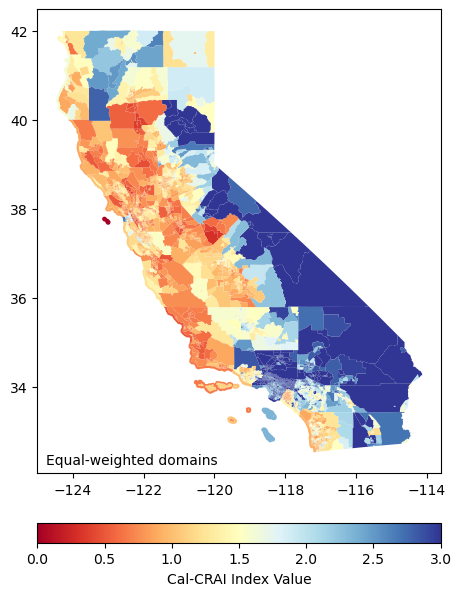

In [17]:
index_plot(calcrai_index_equal_weight, column='calcrai_score', vmin=0, vmax=3)

In [18]:
calcrai_index_equal_weight

,GEOID,governance_domain_index,built_domain_index,natural_systems_domain_index,society_economy_domain_index,built_median,natural_systems_median,society_economy_median,natural_systems_tract_adjusted,society_economy_tract_adjusted,built_tract_adjusted,climate_risk,calcrai_weighted,calcrai_score
0,06001400100,0.651308,0.605062,0.518637,0.638723,0.642475,0.451652,0.58114,0.148310,0.099085,-0.058232,0.753671,0.774511,1.027651
1,06001400200,0.651308,0.553534,0.366578,0.646435,0.642475,0.451652,0.58114,-0.188363,0.112357,-0.138434,0.704640,0.511641,0.726103
2,06001400300,0.651308,0.557473,0.338360,0.601674,0.642475,0.451652,0.58114,-0.250839,0.035334,-0.132304,0.764024,0.424777,0.555974
3,06001400400,0.651308,0.549355,0.358216,0.580613,0.642475,0.451652,0.58114,-0.206877,-0.000908,-0.144939,0.702309,0.421576,0.600272
4,06001400500,0.651308,0.552923,0.367882,0.557130,0.642475,0.451652,0.58114,-0.185476,-0.041315,-0.139386,0.781995,0.412814,0.527899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,06115040902,0.682143,0.468943,0.471736,0.644506,0.642475,0.451652,0.58114,0.044468,0.109036,-0.270099,0.409434,0.602609,1.471808
9125,06115041001,0.682143,0.416459,0.466137,0.607022,0.642475,0.451652,0.58114,0.032071,0.044536,-0.351789,0.382023,0.494429,1.294241
9126,06115041002,0.682143,0.432561,0.584687,0.629400,0.642475,0.451652,0.58114,0.294550,0.083044,-0.326726,0.396227,0.716842,1.809170
9127,06115041101,0.682143,0.391202,0.683639,0.601162,0.642475,0.451652,0.58114,0.513641,0.034453,-0.391102,0.361174,0.789234,2.185191


Number of invalid geometries: 0


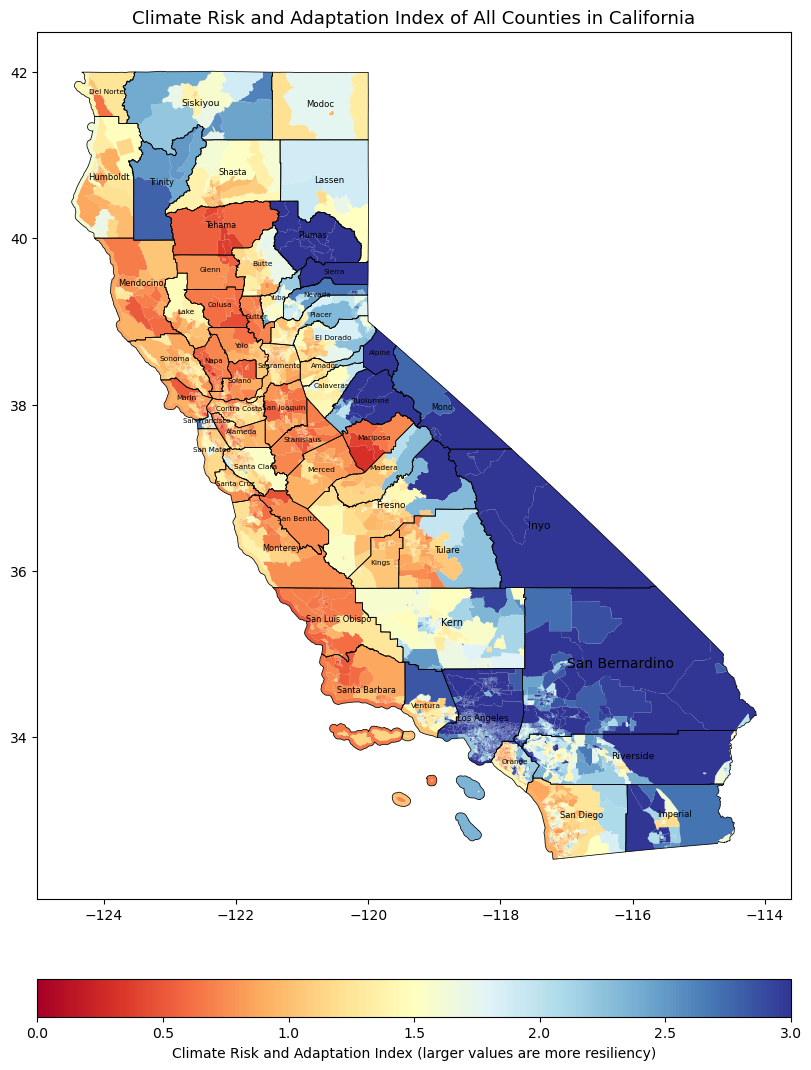

In [19]:
plot_region_domain(calcrai_index_equal_weight, counties_to_plot=None,
                   plot_all=True, savefig=False, font_color='black', domain='',
                   domain_label_map=None, vmin=0, vmax=3, column_to_plot='calcrai_score',cmap='RdYlBu',
                   intro_title='Climate Risk and Adaptation Index')

Number of invalid geometries: 0


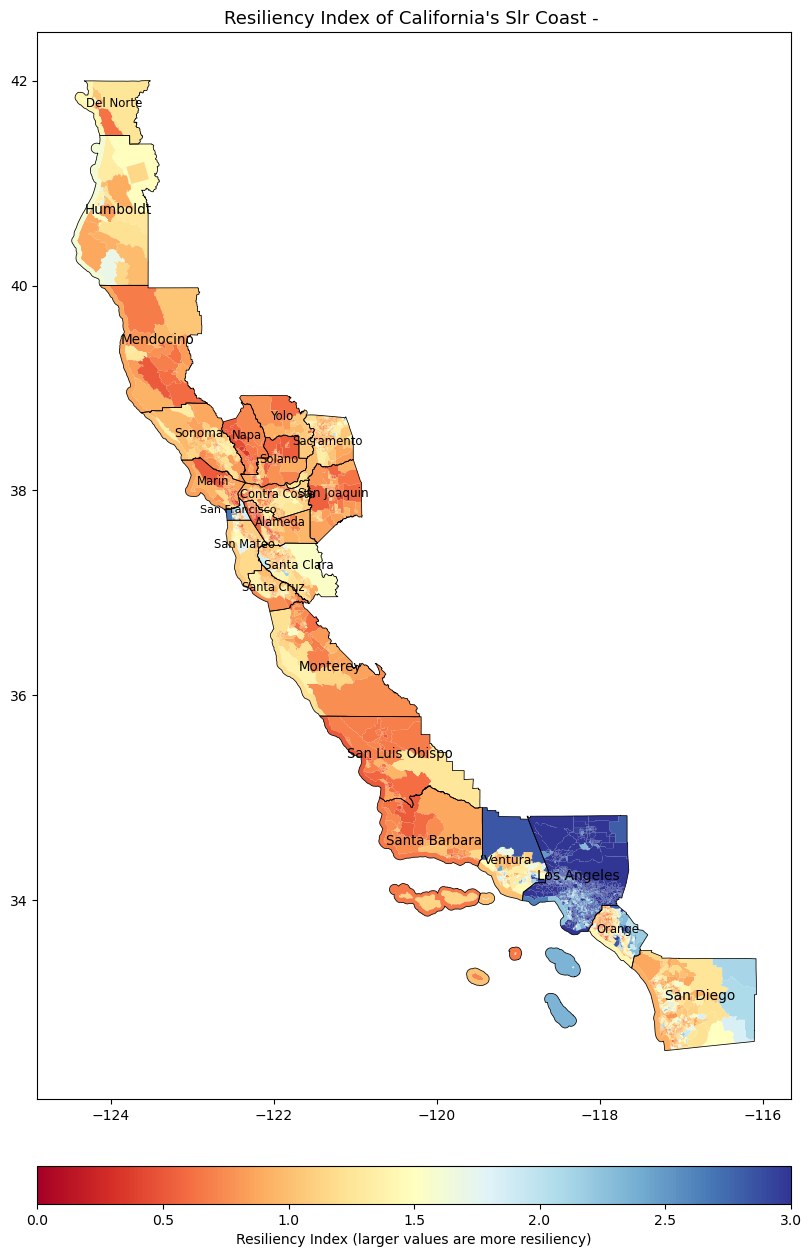

In [ ]:
plot_region_domain(calcrai_index_equal_weight, counties_to_plot=None, region='slr_coast',
                   plot_all=False, savefig=False, font_color='black', domain='',
                   domain_label_map=None, vmin=0, vmax=3, column_to_plot='calcrai_score',cmap='RdYlBu',
                   intro_title='Climate Risk and Adaptation Index')